In [2]:
import random
import os
import glob
import time
import shutil
import itertools
import cv2

from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, RandomContrast, RandomBrightness, RandomTranslation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

In [3]:
train = pd.read_csv('/kaggle/input/model-datatest-skincancer/train_data.csv')
val = pd.read_csv('/kaggle/input/model-datatest-skincancer/val_data.csv')
test = pd.read_csv('/kaggle/input/model-datatest-skincancer/test_data_remove_unk.csv')

In [32]:
class CFG:
    EPOCHS = 15
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    WIDTH = 224
    HEIGHT = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [33]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis']),
    y=train['diagnosis']
)
class_weights_dict = dict(enumerate(class_weights))

In [34]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1, (17, 17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # apply thresholding to blackhat
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
    
    return final_image

In [35]:
def load_image(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    image_uint8 = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    
    image_uint8 = tf.numpy_function(hair_remove, [image_uint8], tf.uint8)
    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.
    
    # Return image
    return image

In [36]:
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

In [37]:
def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    image_paths = df.path_jpg
    image_labels = df.diagnosis
    AUTOTUNE = tf.data.AUTOTUNE
    
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y))
    else:
        ds = ds.map(lambda x, y: (load_function(x), y))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    ds = ds.batch(batch_size)
    
    if cache is not None:
        ds = ds.cache(cache)
    
    if prefetch:
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Return the dataset
    return ds

In [38]:
train_ds = create_pipeline(train, load_image, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=True, prefetch=True)

val_ds = create_pipeline(val, load_image, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)


In [39]:
def InceptionResNetV2_model(input_shape=CFG.IMAGE_SIZE, num_classes=8):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, kernel_regularizer='l2', activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    tl_model = Model(inputs=base_model.input, outputs=predictions)
    
    return tl_model

In [40]:

IRNV2_model = InceptionResNetV2_model()

In [41]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False, class_weight=None):

    
    model_history = {}
    
    if not tf_valid_data:
        validation_data = None
        validation_steps = None
    else:
        validation_data = tf_valid_data
        validation_steps = int(len(tf_valid_data))
        
    model_history = model.fit(tf_train_data,
                              epochs=num_epochs,
                              validation_data=validation_data,
                              validation_steps=validation_steps,
                              callbacks=callbacks_list,
                              shuffle=shuffling,
                             class_weight=class_weight)
        
    return model_history

In [43]:
optimizer = Adam(0.0001)
IRNV2_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [44]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn121.keras', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [45]:
print(f'Training {IRNV2_model.name}.')
print(f'Train on {len(train)} samples, validate on {len(val)} samples.')
print('----------------------------------')

IRNV2_history = train_model(
    IRNV2_model, CFG.EPOCHS, callback_list, 
    train_ds, val_ds,
    shuffling=False,class_weight=class_weights_dict 
)

Training functional_5.
Train on 20264 samples, validate on 5067 samples.
----------------------------------
Epoch 1/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3725 - loss: 3.7837
Epoch 1: val_accuracy improved from -inf to 0.58713, saving model to best_model_dn121.keras
634/634 ━━━━━━━━━━━━━━━━━━━━ 1024s 1s/step - accuracy: 0.3727 - loss: 3.7830 - val_accuracy: 0.5871 - val_loss: 2.6158 - learning_rate: 1.0000e-04
Epoch 2/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 522s 794ms/step - accuracy: 0.5765 - loss: 2.5056 - learning_rate: 1.0000e-04
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accura

634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.6236 - loss: 1.9308
Epoch 3: val_accuracy did not improve from 0.58713
634/634 ━━━━━━━━━━━━━━━━━━━━ 574s 878ms/step - accuracy: 0.6236 - loss: 1.9306 - val_accuracy: 0.5506 - val_loss: 2.0506 - learning_rate: 1.0000e-04
Epoch 4/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 509s 775ms/step - accuracy: 0.6655 - loss: 1.4897 - learning_rate: 1.0000e-04
Epoch 5/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.6835 - loss: 1.2511
Epoch 5: val_accuracy improved from 0.58713 to 0.71679, saving model to best_model_dn121.keras
634/634 ━━━━━━━━━━━━━━━━━━━━ 572s 874ms/step - accuracy: 0.6835 - loss: 1.2510 - val_accuracy: 0.7168 - val_loss: 1.1805 - learning_rate: 1.0000e-04
Epoch 6/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 509s 775ms/step - accuracy: 0.7250 - loss: 0.9740 - learning_rate: 1.0000e-04
Epoch 7/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.7380 - loss: 0.8689
Epoch 7: val_accuracy improved from 0.71679 to 0.74186, saving mode

<Axes: >

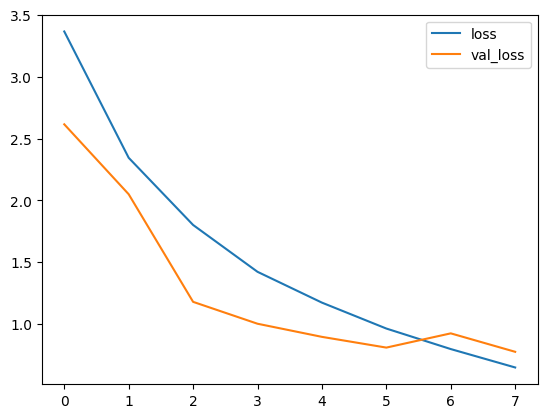

In [47]:
history_dict = IRNV2_model.history.history
min_length = min(len(history_dict["loss"]), len(history_dict["val_loss"]))
metrics = pd.DataFrame({
    "loss": history_dict["loss"][:min_length],
    "val_loss": history_dict["val_loss"][:min_length]
})
metrics.plot()

# Test ds

In [48]:
def create_pipeline_test(df, load_image, batch_size=32, prefetch=True):
    image_paths = df["path_jpg"].values
    dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(load_image)

    dataset = dataset.batch(batch_size)

    if prefetch:
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [49]:
test_ds = create_pipeline_test(test, load_image, batch_size=CFG.BATCH_SIZE, prefetch=True)

# Eval

In [50]:
best_model = tf.keras.models.load_model("/kaggle/working/best_model_dn121.keras")

In [51]:
test_preds = best_model.predict(test_ds)

194/194 ━━━━━━━━━━━━━━━━━━━━ 171s 837ms/step


In [52]:
test_labels_pred = np.argmax(test_preds, axis=1)

In [53]:
test['prediction'] = test_labels_pred

In [54]:
test_data = test[['image', 'prediction']]

In [55]:
test_data

,image,prediction
0,ISIC_0034321,5
1,ISIC_0034322,5
2,ISIC_0034323,6
3,ISIC_0034324,5
4,ISIC_0034325,5
...,...,...
6186,ISIC_0073226,1
6187,ISIC_0073234,5
6188,ISIC_0073236,1
6189,ISIC_0073243,1


In [56]:
class_mapping = {0: 'AK', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'SCC', 7: 'VASC'}
test_data['diagnosis'] = test_data['prediction'].map(class_mapping)
test_data.head()

<ipython-input-56-dead8306c724>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['diagnosis'] = test_data['prediction'].map(class_mapping)


,image,prediction,diagnosis
0,ISIC_0034321,5,NV
1,ISIC_0034322,5,NV
2,ISIC_0034323,6,SCC
3,ISIC_0034324,5,NV
4,ISIC_0034325,5,NV


In [57]:
test_gt = pd.read_csv('/kaggle/input/model-datatest-skincancer/test_gt_remove_unk.csv')
test_gt.head()

,image,diagnosis
0,ISIC_0034321,NV
1,ISIC_0034322,NV
2,ISIC_0034323,BCC
3,ISIC_0034324,NV
4,ISIC_0034325,NV


In [58]:
accuracy = (test_data['diagnosis'] == test_gt['diagnosis']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6312
